# DPL with TensorFlow

**Author**: Nicolas Antoniou<br>
**Project**: Tweet Emotion Recognition Project<br>
**Created**: 24/12/2025<br>
**Finalized**: 26/12/2025<br>
**Data Source:** `merged_training.pkl` → `emotion_dataset.csv` (processed) <br> 
**Labels:** `label_mapping.json`<br>

## Purpose
This notebook trains and evaluates a sequence-based deep learning model for emotion classification.
The same fixed train/validation/test splits are used to ensure fair comparison with the baseline model.
All design choices are documented and evaluation is interpreted in light of known linguistic ambiguity
and human subjectivity in emotion annotation.

________

## Importing the Data

In [1]:
# importing the libs
import pandas as pd
import numpy as np
import json
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set_theme(style="darkgrid")
plt.rcParams["font.family"] = "Times New Roman"

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DATA_DIR = Path("../data/processed")
TRAIN_PATH = DATA_DIR / "train.csv"
VAL_PATH   = DATA_DIR / "val.csv"
TEST_PATH  = DATA_DIR / "test.csv"

LABELMAP_PATH = DATA_DIR / "label_mapping.json"

In [4]:
try:
    with open(LABELMAP_PATH, "r", encoding="utf-8") as f:
        emotion_to_id = json.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"Label mapping file not found at: {LABELMAP_PATH}")
except json.JSONDecodeError:
    raise ValueError(f"Label mapping file is malformed JSON: {LABELMAP_PATH}")
except Exception as e:
    raise RuntimeError(f"Unexpected error while loading label mapping: {e}")

# Reverse mapping
id_to_emotion = {v: k for k, v in emotion_to_id.items()}

# Ordered list for plots
label_names = [id_to_emotion[i] for i in sorted(id_to_emotion)]

print("Loaded label mapping:")
print(emotion_to_id)
print("\nLabel names order:")
print(label_names)

Loaded label mapping:
{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

Label names order:
['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


In [5]:
def safe_read_csv(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset file not found at: {path}")
    except pd.errors.EmptyDataError:
        raise ValueError(f"Dataset file is empty: {path}")
    except Exception as e:
        raise RuntimeError(f"Unexpected error while reading {path}: {e}")

    if df.empty:
        raise ValueError(f"Loaded dataframe is empty: {path}")

    required_cols = {"text", "label"}
    if not required_cols.issubset(df.columns):
        raise KeyError(f"Missing required columns in {path}. Required: {required_cols}. Found: {df.columns.tolist()}")

    # Type safety
    df["text"] = df["text"].astype(str).str.strip()
    df["label"] = pd.to_numeric(df["label"], errors="raise").astype(int)

    # Basic sanity: labels should be in mapping
    invalid_labels = set(df["label"].unique()) - set(id_to_emotion.keys())
    if invalid_labels:
        raise ValueError(f"Found labels not present in label mapping: {invalid_labels}")

    return df


train_df = safe_read_csv(TRAIN_PATH)
val_df   = safe_read_csv(VAL_PATH)
test_df  = safe_read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (291766, 2)
Val shape: (62521, 2)
Test shape: (62522, 2)


,text,label
0,i need to pause when i feel agitated,0
1,i hit my lbs gone mark to be exact p so im fee...,2
2,i feel ungrateful cause god gave me so much,4
3,i feel that my advisers amy margaret and pablo...,3
4,i feeling hesitant to accept it,1


Class distributions are verified to confirm that stratification has preserved label proportions.

In [6]:
def label_distribution(df: pd.DataFrame, name: str):
    dist = df["label"].value_counts(normalize=True).sort_index()
    dist.index = dist.index.map(id_to_emotion)
    print(f"\n{name} label distribution:")
    display(dist)

label_distribution(train_df, "Train")
label_distribution(val_df, "Validation")
label_distribution(test_df, "Test")


Train label distribution:


label
anger       0.137514
fear        0.114468
joy         0.338446
love        0.082902
sadness     0.290750
surprise    0.035919
Name: proportion, dtype: float64


Validation label distribution:


label
anger       0.137506
fear        0.114474
joy         0.338446
love        0.082900
sadness     0.290750
surprise    0.035924
Name: proportion, dtype: float64


Test label distribution:


label
anger       0.137520
fear        0.114472
joy         0.338441
love        0.082899
sadness     0.290746
surprise    0.035923
Name: proportion, dtype: float64

## Deep Learning Pipeline

This notebook builds and evaluates a deep learning model for multi-class emotion classification on tweets.

**Goals**
- Load the processed train/validation/test splits and the label mapping.
- Build a TensorFlow text pipeline (vectorization → model).
- Train with reproducible settings and track learning curves.
- Evaluate on the held-out test set and export model + metrics for reuse.

**Artifacts Produced**
- `models/` trained model file
- `reports/` metrics + training history
- `figures/` confusion matrix + learning curves

In [7]:
MAX_VOCAB = 20_000

In [9]:
MAX_LEN = 40 # to cut off narrative outliers

In [10]:
output_mode="int"

In [11]:
from tensorflow.keras.layers import TextVectorization

In [12]:
vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

2025-12-25 23:48:22.967802: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-25 23:48:22.968134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-25 23:48:22.968722: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-25 23:48:22.969478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-25 23:48:22.970165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# adapt of the vectorizer
vectorizer.adapt(train_df["text"])

In [14]:
# sanity check
vocab = vectorizer.get_vocabulary()

print("Vocabulary size: ", len(vocab))
print("First 10 tokens: ", vocab[:10])

Vocabulary size:  20000
First 10 tokens:  ['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'feeling', 'that']


In [16]:
# testing on real text
sample_texts = train_df["text"].iloc[:3]
vectorized = vectorizer(sample_texts)
vectorized

<tf.Tensor: shape=(3, 40), dtype=int64, numpy=
array([[   2,  104,    5, 4661,   33,    2,    3,  307,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  907,   11, 2864,  610, 1954,    5,   27, 2458, 1487,   15,
          17,    8,  682,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,    3,  749,  489,  230,  824,   19,   15,   77,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])>

In [17]:
EMBED_DIM = 128 # large enough

In [18]:
embedding_layer = layers.Embedding(
    input_dim=MAX_VOCAB,
    output_dim=EMBED_DIM,
    mask_zero=True
)

In [19]:
sample_vecs = embedding_layer(vectorized)
sample_vecs.shape

TensorShape([3, 40, 128])

After text vectorization, each sentence is represented as a fixed-length sequence of integer tokens. While this format satisfies the numerical requirements of a neural network, these integers do not encode any semantic meaning by themselves. An embedding layer is therefore introduced to transform discrete token identifiers into continuous, dense vector representations.

An embedding maps each token to a point in a continuous vector space. In this space, semantic relationships between words are learned implicitly during training. Words that frequently appear in similar emotional or contextual environments tend to converge toward nearby positions, while words associated with different emotional states drift farther apart. Meaning is thus not stored explicitly, but emerges geometrically through distance and direction in the embedding space.


The embedding layer outputs a three-dimensional tensor of shape:<br>
**(batch_size, sequence_length, embedding_dimension)**

Padding is applied to shorter sequences to ensure a uniform input shape across batches. Padding tokens do not represent language and must not influence learning. For this reason, the embedding layer is configured with mask_zero=True, which instructs downstream layers to ignore padded positions entirely. This prevents artificial information from being introduced into the learning process and ensures that only real linguistic content contributes to model updates.

The embedding dimension controls the expressive capacity of the semantic space. Larger dimensions allow the model to encode finer distinctions between words but increase the number of trainable parameters and the risk of overfitting. A moderate dimensionality is therefore selected to balance representational power with generalization ability.

At this stage, raw language has been transformed into structured numerical representations suitable for sequence modeling. The data is now ready to be processed by higher-level layers that can learn temporal patterns and map semantic structures to emotional categories.

In [20]:
# the model
from tensorflow.keras import models

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout

In [22]:
vocab = vectorizer.get_vocabulary()
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

20000

In [23]:
NUM_CLASSES = len(label_names)
NUM_CLASSES

6

In [25]:
from tensorflow.keras.layers import Input

In [26]:
from tensorflow.keras import Model

In [27]:
inputs = Input(shape=(1,), dtype=tf.string, name="text")   # IMPORTANT: (1,) string per example
x = vectorizer(inputs)
x = Embedding(input_dim=VOCAB_SIZE, output_dim=128, mask_zero=True)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 40)        │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 40, 128)   │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ embedding_2[0][0… │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,577,286 (9.83 MB)

 Trainable params: 2,577,286 (9.83 MB)

 Non-trainable params: 0 (0.00 B)

__________

#### Build `tf.data.Dataset` pipelines (train/val/test)

Neural networks like to eat data in **small trays** (batches), not as a huge messy table.

So we will convert our pandas DataFrames into `tf.data.Dataset` objects that:
- **shuffle** training data (so the model doesn’t memorize order),
- **batch** examples (so training is fast),
- **prefetch** batches (so the CPU prepares the next batch while the GPU/Metal is working).

**Important:** We keep `text` as raw strings here.
The model will do the text → numbers conversion internally through the `TextVectorization` layer.

In [28]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

In [37]:
def df_to_dataset(df, shuffle=False, batch_size=128):
    texts = df["text"].astype(str).values
    labels = df["label"].astype("int32").values

    # Set a common seed
    SEED = 42
    # Set seed for TensorFlow
    tf.random.set_seed(SEED)
    
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 50000), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [38]:
train_ds = df_to_dataset(train_df, shuffle=True, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=BATCH_SIZE)

# quick sanity checks
for xb, yb in train_ds.take(1):
    print("Text batch_size: ", xb.shape, xb.dtype)
    print("Label batch_size: ", yb.shape, yb.dtype)

Text batch_size:  (128,) <dtype: 'string'>
Label batch_size:  (128,) <dtype: 'int32'>


2025-12-26 10:40:17.963003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Train the model and watch learning curves

Training is the model practicing.
Validation is the model taking a small quiz after each practice round.

We track:
- **loss** (how wrong the model is),
- **accuracy** (how often it gets the right emotion).

##### What to watch:
- If **train improves** but **val gets worse** → the model is **memorizing** (overfitting).
- If **both are bad** → the model is **too weak** or training setup is wrong (underfitting).

We use callbacks:
- **EarlyStopping**: stops when validation stops improving.
- **ReduceLROnPlateau**: lowers learning rate if progress stalls.

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [40]:
EPOCHS = 10

callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
]

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


2025-12-26 10:45:28.345165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-26 10:45:28.365401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.8497 - loss: 0.4021 - val_accuracy: 0.8922 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 2/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9093 - loss: 0.1951 - val_accuracy: 0.8913 - val_loss: 0.2177 - learning_rate: 0.0010
Epoch 3/10
2279/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9173 - loss: 0.1660
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9162 - loss: 0.1656 - val_accuracy: 0.8919 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 4/10
2278/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9231 - loss: 0.1449
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9244 - loss: 0.1401 - val_accuracy: 0.8904 - val_loss: 0.2478 - learning_rate: 5.0000e-04


Numbers alone are boring.
We plot loss/accuracy to *see* if the model is learning properly.

We want validation curves to improve alongside training.
If validation starts getting worse while training improves, that's overfitting.

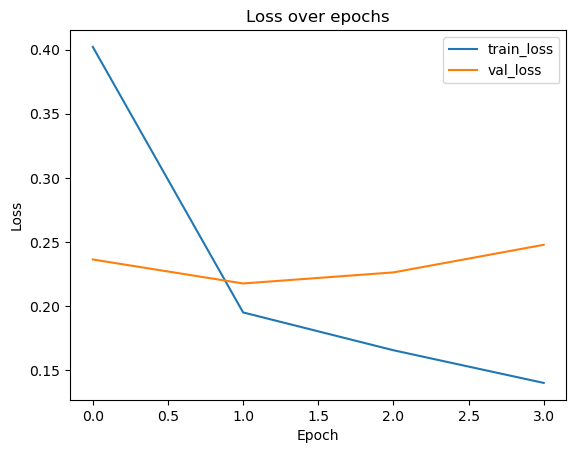

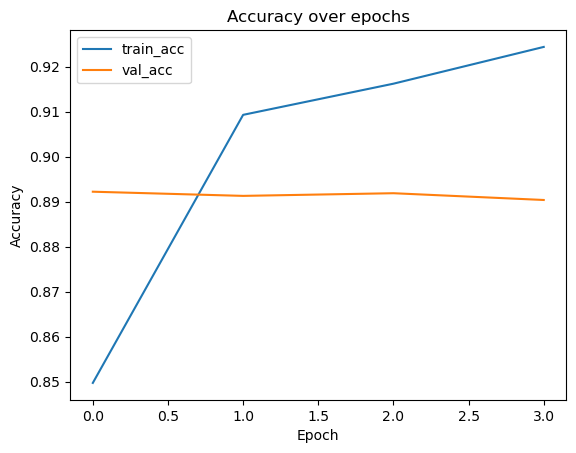

In [42]:
def plot_history(hist):
    h = hist.history

    plt.figure()
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)

The test set is the **final exam**.
We do not use it while training.

This gives a realistic estimate of how well the model will work on new, unseen tweets.

In [43]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

489/489 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8942 - loss: 0.2159
Test loss: 0.216
Test accuracy: 0.894


In [44]:
# Fill these from -2
baseline_test_acc = 0.91
baseline_macro_f1 = 0.88

print("Baseline test accuracy:", baseline_test_acc)
print("Deep model test accuracy:", test_acc)

Baseline test accuracy: 0.91
Deep model test accuracy: 0.8942132592201233


#### Error Analysis

In [45]:
probs = model.predict(test_ds, verbose=1)           # shape: (N, NUM_CLASSES)
y_pred = np.argmax(probs, axis=1)

  1/489 ━━━━━━━━━━━━━━━━━━━━ 3:09 389ms/step

2025-12-26 10:58:51.127898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [46]:
y_true = test_df["label"].astype(int).values

print("probs shape:", probs.shape)
print("y_pred shape:", y_pred.shape, "y_true shape:", y_true.shape)

probs shape: (62522, 6)
y_pred shape: (62522,) y_true shape: (62522,)


_______

### Error Analysis 2.0 
The model outputs a probability for each emotion. Its **confidence** is the biggest probability it gives.

- If the model says “joy: 0.97” and it’s correct → great (high confidence + correct).
- If it says “joy: 0.97” and it’s wrong → that’s dangerous (overconfident).
- If it says “joy: 0.40” and it’s wrong → that’s normal uncertainty.

We check whether “confidence” actually means “more likely correct”.
If accuracy does **not** increase as confidence increases, the model is poorly calibrated.

In [47]:
conf = probs.max(axis=1)
pred = y_pred
true = y_true
correct = (pred == true)

df_conf = pd.DataFrame({
    "conf": conf,
    "correct": correct.astype(int),
    "y_true": true,
    "y_pred": pred
})

In [48]:
bins = np.linspace(0, 1, 11)  # 10 bins
df_conf["bin"] = pd.cut(df_conf["conf"], bins=bins, include_lowest=True)

bucket = df_conf.groupby("bin").agg(
    n=("correct", "size"),
    acc=("correct", "mean"),
    avg_conf=("conf", "mean")
).reset_index()

bucket

/var/folders/cr/f851nq8d2x1760kd65n74rqc0000gn/T/ipykernel_33097/2941466436.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket = df_conf.groupby("bin").agg(


,bin,n,acc,avg_conf
0,"(-0.001, 0.1]",0,NaN,NaN
1,"(0.1, 0.2]",0,NaN,NaN
2,"(0.2, 0.3]",17,0.117647,0.274029
3,"(0.3, 0.4]",201,0.383085,0.363507
4,"(0.4, 0.5]",853,0.454865,0.467017
5,"(0.5, 0.6]",5541,0.455874,0.542447
6,"(0.6, 0.7]",2338,0.495723,0.645591
7,"(0.7, 0.8]",1829,0.607436,0.750278
8,"(0.8, 0.9]",2320,0.762069,0.854704
9,"(0.9, 1.0]",49423,0.988953,0.991715


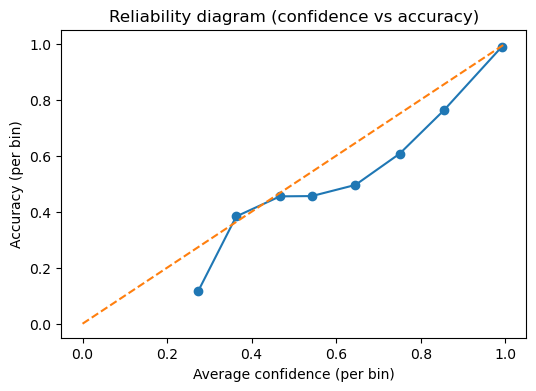

0.023347448545817676

In [49]:
plt.figure(figsize=(6,4))
plt.plot(bucket["avg_conf"], bucket["acc"], marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Average confidence (per bin)")
plt.ylabel("Accuracy (per bin)")
plt.title("Reliability diagram (confidence vs accuracy)")
plt.show()

ece = np.sum((bucket["n"]/bucket["n"].sum()) * np.abs(bucket["acc"] - bucket["avg_conf"]))
ece

Lexical bias means: the model may “cheat” by relying on a few trigger words.

Example:
- If the word “love” appears, it may predict the class “love” even when the sentence is actually sadness.
- If “angry” appears, it may over-predict anger.

We measure this by looking at **which tokens appear most** in:
1) correct predictions for each class (healthy signal)
2) false positives for each class (bias / shortcut)

In [50]:
test_texts = test_df["text"].astype(str).values
test_tokens = vectorizer(tf.constant(test_texts)).numpy()

In [51]:
vocab = vectorizer.get_vocabulary()
UNK_ID = vocab.index("[UNK]") if "[UNK]" in vocab else 1
PAD_ID = 0

def top_tokens(token_ids_2d, k=15):
    flat = token_ids_2d.reshape(-1)
    flat = flat[(flat != PAD_ID) & (flat != UNK_ID)]
    counts = np.bincount(flat, minlength=len(vocab))
    top = np.argsort(counts)[::-1][:k]
    return [(vocab[i], int(counts[i])) for i in top if counts[i] > 0]

# Example: most common tokens overall
top_tokens(test_tokens, k=20)[:20]

[('i', 100145),
 ('feel', 43241),
 ('and', 36710),
 ('to', 33815),
 ('the', 31625),
 ('a', 23676),
 ('feeling', 19967),
 ('that', 19373),
 ('of', 18786),
 ('my', 16448),
 ('in', 12634),
 ('it', 12189),
 ('like', 10954),
 ('so', 9504),
 ('for', 9355),
 ('im', 9126),
 ('have', 8952),
 ('me', 8858),
 ('but', 8721),
 ('is', 8519)]

In [52]:
# false positives per class
NUM_CLASSES = probs.shape[1]

for c in range(NUM_CLASSES):
    # False positives: predicted c but true != c
    fp_mask = (pred == c) & (true != c)
    fp_tokens = test_tokens[fp_mask]
    print(f"\nClass {c} false positives (n={fp_mask.sum()}): top tokens")
    print(top_tokens(fp_tokens, k=15))

    # True positives: predicted c and true == c
    tp_mask = (pred == c) & (true == c)
    tp_tokens = test_tokens[tp_mask]
    print(f"Class {c} true positives (n={tp_mask.sum()}): top tokens")
    print(top_tokens(tp_tokens, k=15))


Class 0 false positives (n=1112): top tokens
[('i', 2018), ('and', 881), ('feel', 658), ('to', 655), ('the', 634), ('a', 451), ('my', 394), ('that', 390), ('feeling', 343), ('of', 337), ('was', 253), ('like', 231), ('in', 229), ('it', 224), ('me', 222)]
Class 0 true positives (n=7889): top tokens
[('i', 12636), ('feel', 5213), ('and', 4254), ('to', 3940), ('the', 3603), ('a', 2789), ('feeling', 2663), ('that', 2307), ('of', 2161), ('my', 1862), ('it', 1457), ('like', 1418), ('in', 1322), ('im', 1254), ('me', 1214)]

Class 1 false positives (n=1128): top tokens
[('i', 1818), ('feel', 758), ('and', 689), ('to', 594), ('the', 571), ('a', 438), ('feeling', 365), ('of', 344), ('that', 343), ('my', 288), ('in', 250), ('was', 219), ('it', 204), ('so', 203), ('but', 180)]
Class 1 true positives (n=6002): top tokens
[('i', 9519), ('feel', 3859), ('to', 3444), ('and', 3247), ('the', 2737), ('feeling', 2275), ('a', 2126), ('of', 1771), ('that', 1611), ('my', 1544), ('in', 1090), ('it', 1083), ('

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true, pred, digits=4))

cm = confusion_matrix(true, pred)
cm

              precision    recall  f1-score   support

           0     0.8765    0.9175    0.8965      8598
           1     0.8418    0.8386    0.8402      7157
           2     0.9279    0.9114    0.9196     21160
           3     0.7547    0.8329    0.7919      5183
           4     0.9510    0.9204    0.9355     18178
           5     0.7337    0.7493    0.7414      2246

    accuracy                         0.8942     62522
   macro avg     0.8476    0.8617    0.8542     62522
weighted avg     0.8964    0.8942    0.8950     62522



array([[ 7889,   260,   119,    31,   282,    17],
       [  302,  6002,   158,    39,   248,   408],
       [  152,    99, 19286,  1240,   247,   136],
       [   41,    10,   767,  4317,    43,     5],
       [  602,   432,   292,    76, 16731,    45],
       [   15,   327,   162,    17,    42,  1683]])

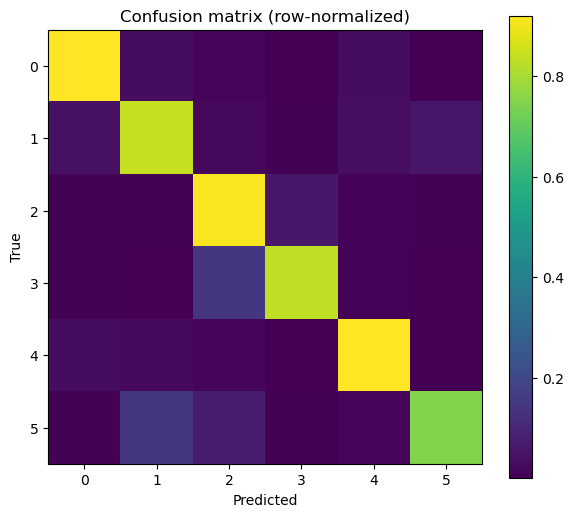

In [54]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion matrix (row-normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [55]:
rep = classification_report(true, pred, output_dict=True)
rows = []
for c in range(NUM_CLASSES):
    rows.append({
        "class": c,
        "precision": rep[str(c)]["precision"],
        "recall": rep[str(c)]["recall"],
        "f1": rep[str(c)]["f1-score"],
        "support": rep[str(c)]["support"]
    })
df_rep = pd.DataFrame(rows).sort_values("support", ascending=False)
df_rep

,class,precision,recall,f1,support
2,2,0.927925,0.911437,0.919607,21160.0
4,4,0.951003,0.920398,0.935451,18178.0
0,0,0.876458,0.917539,0.896528,8598.0
1,1,0.841795,0.838620,0.840204,7157.0
3,3,0.754720,0.832915,0.791892,5183.0
5,5,0.733653,0.749332,0.741410,2246.0


_______

In [57]:
from pathlib import Path

ARTIFACTS_DIR = Path("../artifacts")
MODELS_DIR = ARTIFACTS_DIR / "models"
REPORTS_DIR = ARTIFACTS_DIR / "reports"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

for d in [MODELS_DIR, REPORTS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [61]:
MODEL_PATH = MODELS_DIR / "emotion_classifier_tf.keras"
model.save(MODEL_PATH)

MODEL_PATH

PosixPath('../artifacts/models/emotion_classifier_tf.keras')

In [59]:
import json

metrics = {
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss),
    "baseline_accuracy": 0.91,
    "deep_model_accuracy": float(test_acc),
    "num_classes": NUM_CLASSES,
    "vocab_size": MAX_VOCAB,
    "sequence_length": MAX_LEN,
}

with open(REPORTS_DIR / "metrics_summary.json", "w") as f:
    json.dump(metrics, f, indent=4)

In [60]:
df_rep.to_csv(REPORTS_DIR / "classification_report.csv", index=False)